In [83]:
import sys
if '../' not in sys.path:
    sys.path.append('../')
from src.data.parse_data import *
from src.visualization.advanced_visualizations import *
import pandas as pd
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm

In [2]:
dfs = list()
for i in range(1, 9):
    dfs.append((parse_data(f'Assay {i}.xlsx'), f'Assay {i}.xlsx'))

Assay 1.xlsx - deleted 15 rows with invalid Transfer Status
Assay 2.xlsx - deleted 4 rows with invalid Transfer Status
Assay 3.xlsx - deleted 2 rows with invalid Transfer Status


In [5]:
df = combine_assays(dfs)

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [6]:
# display(df.head())
columns = ['CMPD ID']
columns.extend(list(df.filter(like='% ACTIVATION - ').columns))
columns.extend(list(df.filter(like='% INHIBITION - ').columns))
df = df[columns]

In [14]:
df = df.dropna(inplace=False)
df.head()

,CMPD ID,% ACTIVATION - Assay 1,% ACTIVATION - Assay 2,% ACTIVATION - Assay 3,% ACTIVATION - Assay 8,% INHIBITION - Assay 4,% INHIBITION - Assay 5,% INHIBITION - Assay 6,% INHIBITION - Assay 7,% INHIBITION - Assay 8
0,99629.0,-3.129952,-3.698817,1.101322,-8.653272,17.492189,5.387032,-15.886739,5.901682,12.961859
1,99630.0,0.145774,1.047107,1.353052,-8.812413,36.465913,0.268495,-17.203030,9.897476,13.200238
2,99631.0,0.542907,0.102929,1.750517,-4.993038,12.123849,7.580691,-15.360223,10.528391,7.479142
3,99632.0,-0.377752,1.436619,0.346130,3.759698,-7.403485,4.473008,-19.356962,-2.931125,-5.631704
5,99634.0,-0.840498,-0.173915,0.849591,-5.311319,10.530124,4.198800,-22.073308,3.378023,7.955900


In [15]:
def get_umap_2(df: pd.DataFrame, target: str, scaler: object = None,
             n_neighbors=10, n_components=2, min_dist=0.2) -> np.ndarray:
    """
    :param df: DataFrame with to perform UMAP

    :param target: names of column to be treated as target

    :param scaler: object with which scaling will be performed

    :return: UMAP array, target y
    """
    df_na = df.dropna(inplace=False)
    X = df_na.drop(target, axis=1)
    y = df_na[target]

    
    umap_transformer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist
    )
    if scaler is not None:
        X_scaled = scaler.fit_transform(X)
        X_umap = umap_transformer.fit_transform(X_scaled)
    else:
        X_umap = umap_transformer.fit_transform(X)

    return X_umap, y

In [112]:
UMAP, y = get_umap_2(df, 'CMPD ID')

In [117]:
# TODO
class MidpointNormalize(Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [134]:
def plot_multiple_umap_2(X_umap: np.ndarray, y: np.ndarray, df: pd.DataFrame) -> None:
    """
    Show scatter plots for the UMAP data, colored by activation/inibition in each assay

    :param X_umap: DataFrame to be visualized

    :param y: name of feature for x-axis

    :return: scatter plot for UMAPs
    """
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 14))
    fig.suptitle('UMAP projection of assays', fontsize=16)

    for col, i, ax in zip(df.columns[1:], range(9), axs.ravel()):
        ax.scatter(
            X_umap[:, 0],
            X_umap[:, 1],
            c=df[col], 
            cmap='coolwarm', 
            s=5)
        ax.set_title(col)
        # norm = Normalize(vmin=max(1, df[col].mean()-3*df[col].std()), 
        #                     vmax=df[col].mean()+3*df[col].std(), clip=True)
        norm = MidpointNormalize(vmin=df[col].mean()-3*df[col].std(), 
                            vmax=df[col].mean()+3*df[col].std(),midpoint=0)
        # norm = LogNorm(vmin=max(1, df[col].mean()-3*df[col].std()), 
        #                     vmax=df[col].mean()+3*df[col].std(), clip=True)
        # norm=TwoSlopeNorm(vmin=df[col].min(), vcenter=0, vmax=df[col].max())
        sm = ScalarMappable(norm=norm, cmap='coolwarm')
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
    plt.show()

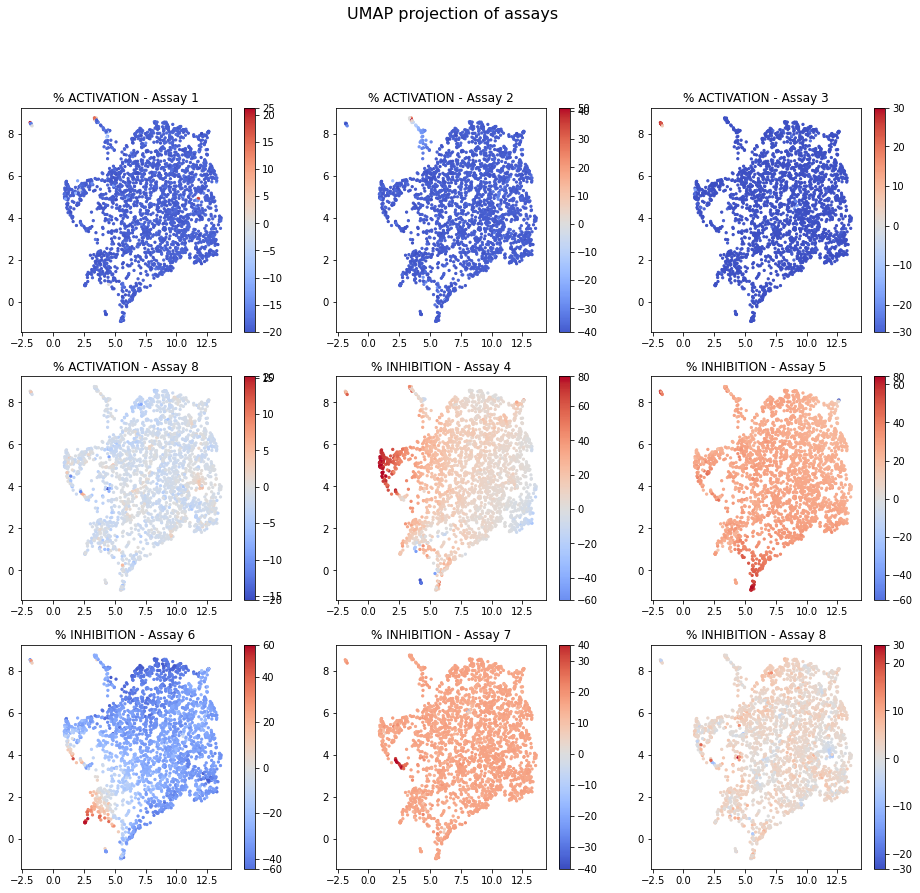

In [135]:
plot_multiple_umap_2(UMAP, 'CMPD ID', df)